In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events, get_fields
from filestore.api import register_handler, deregister_handler
#from filestore.retrieve import _h_registry, _HANDLER_CACHE, HandlerBase
from eiger_io.pims_reader import EigerImages
from chxtools import handlers
 
## Import all the required packages for  Data Analysis

#* scikit-beam - data analysis tools for X-ray science 
#    - https://github.com/scikit-beam/scikit-beam
#* xray-vision - plotting helper functions for X-ray science
#    - https://github.com/Nikea/xray-vision

import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skbeam.core.roi as roi
import skbeam.core.correlation as corr
import skbeam.core.utils as utils

import numpy as np
from datetime import datetime
import h5py
 
import pims
from pandas import DataFrame
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib notebook

/opt/conda_envs/analysis/lib/python3.4/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


In [8]:

def load_data( uid , detector = 'eiger4m_single_image'  ):
    '''Load data by giving uid and detector    
    '''
    hdr = db[uid]
    flag =1
    while flag<4 and flag !=0:    
        try:
            ev, = get_events(hdr, [detector]) 
            flag =0 
        except:
            flag += 1        
            print ('Trying again ...!')

    if flag:
        print ("Can't Load Data!")
        uid = '00000'  #in case of failling load data
        imgs = 0
    else:
        imgs = ev['data'][detector]
    print (imgs)
    return imgs


def load_mask( path, mask_name, plot_ = False ):
    '''give path and mask_name to load mask'''
    mask = np.load(    path +   mask_name )
    if plot_:
        show_img( mask )
    return mask


def show_img( img ):
    fig, ax = plt.subplots()
    im=ax.imshow(img, origin='lower' ,cmap='viridis',interpolation="nearest")  #vmin=0,vmax=1,
    fig.colorbar(im)
    plt.show()

In [2]:

def circular_average(image, calibrated_center, threshold=0, nx=None,
                     pixel_size=(1, 1),  min_x=None, max_x=None, mask=None):
    """Circular average of the the image data
    The circular average is also known as the radial integration
    Parameters
    ----------
    image : array
        Image to compute the average as a function of radius
    calibrated_center : tuple
        The center of the image in pixel units
        argument order should be (row, col)
    threshold : int, optional
        Ignore counts above `threshold`
        default is zero
    nx : int, optional
        number of bins in x
        defaults is 100 bins
    pixel_size : tuple, optional
        The size of a pixel (in a real unit, like mm).
        argument order should be (pixel_height, pixel_width)
        default is (1, 1)
    min_x : float, optional number of pixels
        Left edge of first bin defaults to minimum value of x
    max_x : float, optional number of pixels
        Right edge of last bin defaults to maximum value of x
    Returns
    -------
    bin_centers : array
        The center of each bin in R. shape is (nx, )
    ring_averages : array
        Radial average of the image. shape is (nx, ).
    """
    radial_val = utils.radial_grid(calibrated_center, image.shape, pixel_size) 
    ps =np.min( pixel_size )
    if max_x is None:max_x = np.max(radial_val)/ps
    if min_x is None:min_x = np.min(radial_val)/ps        
    if nx is None:        
        nx = int(max_x - min_x)        
    if mask is not None:          
        mask = np.array( mask, dtype = bool)
        binr = radial_val[mask]
        image_mask =     np.array( image )[mask]        
    else:        
        binr = np.ravel( radial_val ) 
        image_mask = np.ravel(image)         
    bin_edges, sums, counts = utils.bin_1D( binr,
                                           image_mask,
                                           nx,
                                           min_x=min_x,
                                           max_x=max_x)   
    
    th_mask = counts > threshold
    ring_averages = sums[th_mask] / counts[th_mask]
    bin_centers = utils.bin_edges_to_centers(bin_edges)[th_mask]
    return bin_centers, ring_averages 



In [3]:
dpix = 0.075  #in eiger 4M, mm
detector = 'eiger4m_single_image'
Ldet = 4840 #
lambda_  = 1.4250998


center = [1210, 1328]  # center of the speckle pattern
center = [1209, 2167-837]  # center of the speckle pattern

center=[center[1], center[0]]




path = '/XF11ID/analysis/2016_1/CFN/Results/'
print ("The analysis results will be saved in : %s"%path)
#mask_name = "SAXS_mask.npy"
mask_name = "SAXS_mask_0314.npy"

The analysis results will be saved in : /XF11ID/analysis/2016_1/CFN/Results/


In [5]:
uid ='80532f5a'


In [6]:
imgs = load_data( uid, detector  )
md = imgs.md

hdf5 path = /XF11ID/data/2016/03/15/3e23a481-e875-49cb-8af3_4225_master.h5
<Frames>
Length: 3000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


<IPython.core.display.Javascript object>


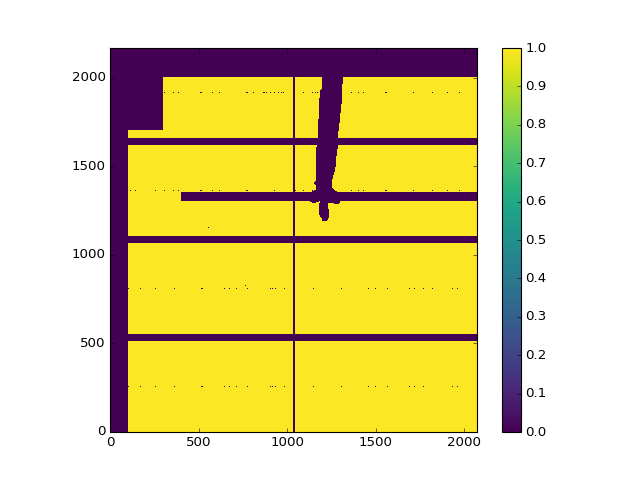

In [9]:
mask = load_mask( path, mask_name, plot_ =  True )

In [10]:
mask

array([[ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [14]:
avg_img = np.average(imgs[:50:1], axis=0)

<IPython.core.display.Javascript object>


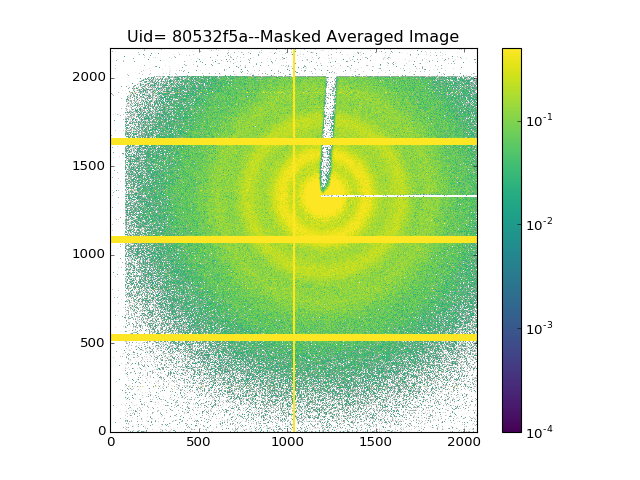

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(avg_img , cmap='viridis',origin='lower',
           norm= LogNorm(vmin=0.0001, vmax=.5))
#ax.set_title("Masked Averaged Image")
ax.set_title('Uid= %s--Masked Averaged Image'%uid)
fig.colorbar(im)
plt.show()

# Test 1 No mask
--obviously this is wrong

In [22]:
q, iq = circular_average(avg_img, 
        center, threshold=0, nx= None, pixel_size=(dpix, dpix), mask= None)


<IPython.core.display.Javascript object>


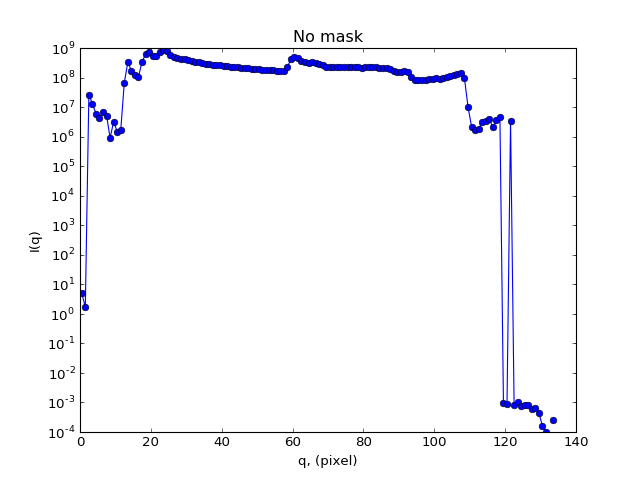

In [24]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q, iq, '-o')
axes.set_title('No mask')
axes.set_ylabel('I(q)')
axes.set_xlabel('q, (pixel)')
#axes.set_xlim(30,  1050)
#axes.set_ylim(-0.0001, 10000)
plt.show()

# Test 2 use booleans to mask image
--count more zeros in the denominator

In [26]:
q, iq = circular_average(avg_img*mask, 
        center, threshold=0, nx= None, pixel_size=(dpix, dpix), mask= None)


<IPython.core.display.Javascript object>


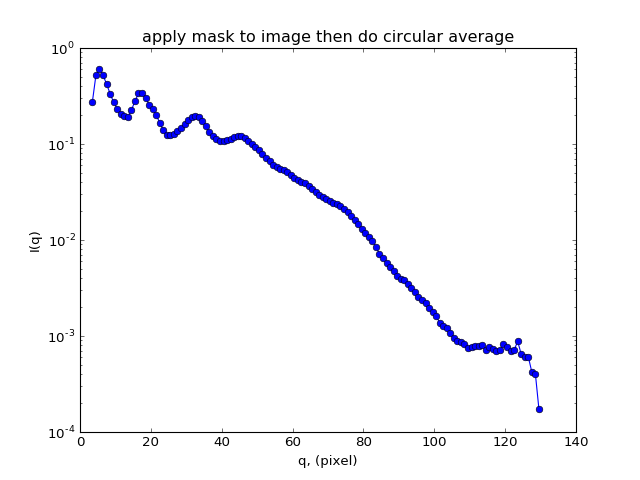

In [28]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q, iq, '-o')
axes.set_title('apply mask to image then do circular average')
axes.set_ylabel('I(q)')
axes.set_xlabel('q, (pixel)')
#axes.set_xlim(30,  1050)
#axes.set_ylim(-0.0001, 10000)
plt.show()

# Test 3 use np.nan to mask image
--The current bin1D histogram for nan is not work
--utils.bin_1D should be changed.

In [31]:
mask[np.where(mask==0)] = np.nan

In [36]:
avg_img = np.array( avg_img, dtype =  float)

In [41]:
avg_img*mask

array([[ nan,  nan,  nan, ...,   0.,   0.,  nan],
       [ nan,  nan,  nan, ...,   0.,   0.,   0.],
       [ nan,  nan,  nan, ...,   0.,   0.,   0.],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [37]:
q, iq = circular_average(avg_img*mask, 
        center, threshold=0, nx= None, pixel_size=(dpix, dpix), mask= None)


In [42]:
iq

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan])

In [38]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q, iq, '-o')
axes.set_title("")
axes.set_ylabel('I(q)')
axes.set_xlabel('q, (pixel)')
#axes.set_xlim(30,  1050)
#axes.set_ylim(-0.0001, 10000)
plt.show()

<IPython.core.display.Javascript object>

ValueError: Data has no positive values, and therefore can not be log-scaled.

# Test 4 use mask option
--a good one

In [15]:
q, iq = circular_average(avg_img, 
        center, threshold=0, nx= None, pixel_size=(dpix, dpix), mask=mask)


<IPython.core.display.Javascript object>


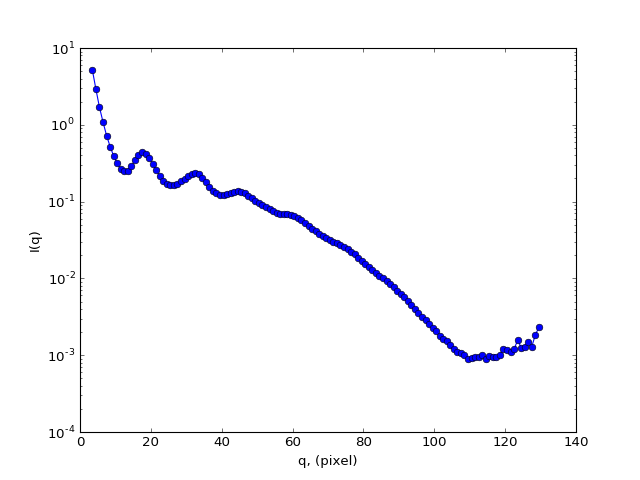

In [16]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q, iq, '-o')
axes.set_title("")
axes.set_ylabel('I(q)')
axes.set_xlabel('q, (pixel)')
#axes.set_xlim(30,  1050)
#axes.set_ylim(-0.0001, 10000)
plt.show()